## AML Package for Text Analytics - Text Classification 
### Text Classification using Convolutional Neural Networks (CNNs) and Word2Vec Embeddings

### Background

Sentiment analysis is the task of extracting the intended subjective information conveyed by a text. It's most common form is for polarity extraction, i.e., distinguishing between positive and negative attitudes toward some item or product.

One major difficulty is that the judgment of the polarity of an opinion can be subjective. Humans, for instance, usually disagree when judging the sentiment of a sentence, typically reaching only modest inter‐annotator agreement.

Moreover, polarity has to be interpreted within a context (contextual polarity). Thus, the polarity of a word can be modified in a sentence due to linguistic phenomena such as negation, modality, intensifiers, diminishers, and word sense.

Deep learning is an emergent area of machine learning that offers methods for learning feature representation in a supervised or unsupervised fashion within a hierarchy. Typically, high layers of the hierarchy will have a more abstract representation (i.e., distributed representation) than lower layers. Higher layers evolve during training to exploit complex compositional nonlinear functions of the lower layers.

We apply deep learning architectures to the task of sentiment analysis on a corpus of [polarized movie reviews](http://ai.stanford.edu/~amaas/data/sentiment/) from the IMDB website. This dataset was curated by Andrew Maas and fellow researchers at Stanford University, and is sometimes referred to as the _large movie review dataset_. We've provided a helper function to download the raw dataset from the URL, and transform it into a pandas DataFrame. 


### Convolutions for Text
In this tutorial we showcase the use of neural networks with convolutions and pooling operations. The main idea behind a convolution and pooling architecture for language tasks is to apply a nonlinear (learned) function over each instantiation of a $k$-word sliding window over the sentence. For our use-case, we use a 1D convolution + maximum pooling over the review using a pre-trained word-embedding matrix.

This architecture looks up each word in the embedding matrix to obtain an embedding vector, and a "window" of embedding vectors are concatenated together prior to the application of non-linearity and a maximum pooling operation to create features to use as predictors of sentiment. A pictorial representation of this operation over a sample sentence is given below (image is from _Yoav Goldberg (2017) - Neural Networks for Natural Language Processing, Morgan & Claypool Publishers_)

![Yoav Goldberg - Neural Networks for Natural Language Processing](../imgs/conv-pool-text.png)

Following are the steps for creating and deploying a custom entity extraction model using the package:
<br> Step 1: Loading dataset and pre-trained embedding model
<br> Step 2: Model training
<br> Step 3: Apply the custom entity extractor 
<br> Step 4: Performance Evaluation
<br> Step 5: Save the pipeline 
<br> Step 6: Load the pipeline 
<br> Step 7: Run the pipeline on unlabeled data
<br> Step 8: Operationalize - Deploy the pipeline

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
!{sys.executable} -m pip show azureml-tatk

Name: azureml-tatk
Version: 0.1.18149.10a1
Summary: Microsoft Azure Machine Learning Package for Text Analytics
Home-page: https://microsoft.sharepoint.com/teams/TextAnalyticsPackagePreview
Author: Microsoft Corporation
Author-email: amltap@microsoft.com
License: UNKNOWN
Location: /anaconda/envs/aztatk/lib/python3.5/site-packages
Requires: scipy, azure-storage, numpy, dill, lxml, pdfminer.six, bqplot, ruamel.yaml, unidecode, nltk, jsonpickle, matplotlib, requests, scikit-learn, azure-ml-api-sdk, h5py, validators, keras, pandas, ipython, pytest, nose, pyspark, docker, sklearn-crfsuite, gensim
Required-by: 


In [3]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import keras

Using TensorFlow backend.


## Step 1: Loading dataset and pre-trained embedding model

We need to download the movie review dataset as well as the embedding model we will use in our network. Please download the data from [IMDB Data](ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and save it to your home directory under `tatk\resources\data\imdb`.

In [4]:
from tatk.utils.load_data import load_imdb_data
resources_dir = os.path.join(os.path.expanduser("~"), "tatk", "resources")
data_dir = os.path.join(resources_dir, "data")

In [5]:
X_train, y_train, X_test, y_test = load_imdb_data(data_dir=str(data_dir))

IMDB dataset already downloaded and loading from /home/alizaidi/tatk/resources/data/imdb/movie_data.csv


### Download the Embedding Model

Download pretrained Google word embedding model [GoogleNews-vectors-negative300.bin.gz](https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download), and save it your home directory under `tatk\resources\models\Word2Vec_Models\`.

In [6]:
from tatk.utils.load_data import models_dir, download_embedding_model
embedding_file_path = download_embedding_model(models_dir, embedding_type="google")
import pathlib
# embedding_file_path = str(pathlib.Path(resources_dir).joinpath("models", "Word2Vec_Models", 
#                                                                "GoogleNews-vectors-negative300.bin"))

In [7]:
imdb_train = pd.DataFrame({'review': X_train, 'sentiment': y_train})
imdb_train[0:5]

,review,sentiment
0,I don't know if it was the directors intent to...,1
1,This extremely low-budget monster flick center...,0
2,The Angry Red Planet (Quickie Review) <br /><b...,0
3,"One of the unsung gems of the 1980's, Scenes.....",1
4,I could not even bring myself to watch this mo...,0


In [8]:
imdb_train['word_counts'] = imdb_train['review'].str.split().apply(len)

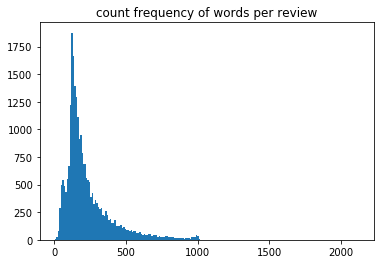

In [9]:
plt.hist(imdb_train['word_counts'], bins = "auto")
plt.title("count frequency of words per review")
plt.show()

In [10]:
print("average unique tokens in a review: ", imdb_train['word_counts'].mean())

average unique tokens in a review:  230.61768


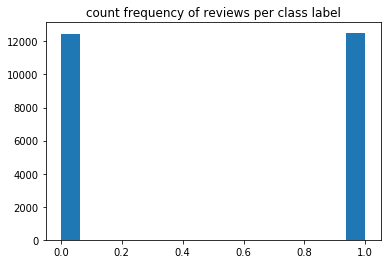

In [11]:
plt.hist(imdb_train['sentiment'], bins = "auto")
plt.title("count frequency of reviews per class label")
plt.show()

There is a large right tail to the length of review, meaning some reviewers are very verbose (over 2000 unique words in one review!), while others are very curt. The minimum length is four unique words:

In [12]:
print(imdb_train[imdb_train["review"].apply(lambda x: len(str.split(x)) == imdb_train['word_counts'].min())]["review"].values)

['Primary plot!Primary direction!Poor interpretation.']


In [13]:
print(imdb_train[imdb_train["review"].apply(lambda x: len(str.split(x)) == imdb_train['word_counts'].max())]["review"].values)

['Back in the mid/late 80s, an OAV anime by title of "Bubblegum Crisis" (which I think is a military slang term for when technical equipment goes haywire) made its debut on video, taking inspiration from "Blade Runner", "The Terminator" and maybe even "Robocop", with a little dash of Batman/Bruce Wayne - Iron Man/Tony Stark and Charlie\'s Angel\'s girl power thrown in for good measure. 8 episodes long, the overall story was that in 21st century Tokyo, Japan, year 2032-2033, living machines called Boomers were doing manual labor and sometimes cause problems. A special, SWAT like branch of law enforcers, the Advanced Police (AD Police for short) were formed to handle the boomers, but were mostly ineffective, prompting millionaire scientist Sylia Stingray, the daughter of the scientist who made the boomers, to create four powered combat armor (hard suits) to be worn by women to fight the boomers and fight the evil corporation that produced the boomers, GENOM. That group becomes known as t

## Step 2: Model training

In [14]:
from tatk.pipelines.text_classification.keras_embedding_text_classifier import KerasEmbeddingTextClassifier
import datetime
log_dir = pathlib.Path(resources_dir) / "logs"
imdb_logs = str(log_dir / "imdb_results" / datetime.datetime.now().strftime("%Y_%m_%d") / "kernel_3")

# the generic word embedding model has 3M words. We load the top <max_features> words as input features to the neural network
max_features=100000

keras_text_classifier = KerasEmbeddingTextClassifier(embedding_file_path, 
                                                     input_col="review", 
                                                     label_cols="sentiment",
                                                     model_type="CNN",
                                                     binary_format=True, 
                                                     limit=max_features,
                                                     cuda_devices="0",
                                                     callbacks=True,
                                                     log_dir=imdb_logs)

KerasEmbeddingTextClassifier::create_pipeline ==> start
Word2VecVectorizer::load_embeddings ==> start
Time taken: 0.03 mins
Word2VecVectorizer::load_embeddings ==> end
num_words=100002
:: number of jobs for the pipeline : 24
0	nltk_preprocessor
1	vectorizer
2	learner
KerasEmbeddingTextClassifier::create_pipeline ==> end


### View and Modify Pipeline and Model Parameters

Since we are using a slice of the full word embedding matrix (i.e., specified by the `limit` parameter and `max_features` value above) it'll be more efficient to not save the entire word-embedding matrix in our saved pipeline. This can be specified by modifying the `get_from_path` argument in the word2vec `vectorizer`. 

In [15]:
keras_text_classifier.get_params()

{'binary_format': True,
 'callbacks': True,
 'class_type': 'single-label',
 'cuda_devices': '0',
 'embedding_file_path': '/home/alizaidi/tatk/resources/models/Word2Vec_Models/GoogleNews-vectors-negative300.bin',
 'input_col': 'review',
 'label_cols': ['sentiment'],
 'limit': 100000,
 'log_dir': '/home/alizaidi/tatk/resources/logs/imdb_results/2018_06_12/kernel_3',
 'model_type': 'CNN',
 'n_labels': None,
 'regex': None,
 'trainable_embedding': False}

In [16]:
keras_text_classifier.get_step_params_by_name("learner")

{'batch_size': 50,
 'callbacks_list': ['tensorboard', 'checkpoint', 'early'],
 'cuda_devices': '0',
 'feature_cols': ['features'],
 'input_padding_value': 100001,
 'label_cols': ['sentiment'],
 'log_path': '/home/alizaidi/tatk/resources/logs/imdb_results/2018_06_12/kernel_3',
 'max_len': None,
 'model__class_type': 'single-label',
 'model__dropout_rate': 0.25,
 'model__hidden_dims': 250,
 'model__init_wordvecs': array([[ 1.12915039e-03, -8.96453857e-04,  3.18527222e-04, ...,
         -1.56402588e-03, -1.23023987e-04, -8.63075256e-05],
        [ 7.03125000e-02,  8.69140625e-02,  8.78906250e-02, ...,
         -4.76074219e-02,  1.44653320e-02, -6.25000000e-02],
        [-1.17797852e-02, -4.73632812e-02,  4.46777344e-02, ...,
          7.12890625e-02, -3.49121094e-02,  2.41699219e-02],
        ...,
        [ 5.03540039e-03, -9.57031250e-02,  1.75781250e-01, ...,
          1.84570312e-01, -2.13867188e-01,  2.63671875e-01],
        [-4.27824607e-02,  5.15116424e-02, -7.92370295e-03, ...,
   

In [17]:
keras_text_classifier.set_step_params_by_name("learner", model__kernel_size=[3])
keras_text_classifier.set_step_params_by_name("vectorizer", get_from_path=False)

In [18]:
keras_text_classifier.fit(imdb_train)

KerasEmbeddingTextClassifier::fit ==> start
schema: col=review:TX:0 col=sentiment:I8:1 col=word_counts:I8:2 header+
F1 2018-06-12 19:18:32,556 INFO azureml.text:machine info {"os_type": "Linux", "is_dsvm": true} 
F1 2018-06-12 19:18:32,559 INFO azureml.text:8352507970292263481 TatkPipeline::fit ==> start 
F1 2018-06-12 19:18:32,571 INFO azureml.text:8352507970292263481 NltkPreprocessor::tatk_fit_transform ==> start 
NltkPreprocessor::tatk_fit_transform ==> start
F1 2018-06-12 19:18:38,906 INFO azureml.text:8352507970292263481 NltkPreprocessor::tatk_fit_transform ==> end 	 Time taken: 0.11 mins 
NltkPreprocessor::tatk_fit_transform ==> end 	 Time taken: 0.11 mins
F1 2018-06-12 19:18:38,912 INFO azureml.text:8352507970292263481 Word2VecVectorizer::tatk_fit_transform ==> start 
Word2VecVectorizer::tatk_fit_transform ==> start
F1 2018-06-12 19:18:45,337 INFO azureml.text:8352507970292263481 Word2VecVectorizer::tatk_fit_transform ==> end 	 Time taken: 0.11 mins 
Word2VecVectorizer::tatk_fit

KerasEmbeddingTextClassifier(binary_format=True, callbacks=True,
               class_type='single-label', cuda_devices='0',
               embedding_file_path='/home/alizaidi/tatk/resources/models/Word2Vec_Models/GoogleNews-vectors-negative300.bin',
               input_col='review', label_cols=['sentiment'], limit=100000,
               log_dir='/home/alizaidi/tatk/resources/logs/imdb_results/2018_06_12/kernel_3',
               model_type='CNN', n_labels=None, regex=None,
               trainable_embedding=False)

## Step 3: Apply the text classifier

In [19]:
imdb_test = pd.DataFrame({'review': X_test, 'sentiment': y_test})
keras_text_classifier.predict(imdb_test)
imdb_test[-5:]

KerasEmbeddingTextClassifier ::predict ==> start
F1 2018-06-12 19:19:49,735 INFO azureml.text:TatkPipeline Prediction starting in experiment 228999593 
F1 2018-06-12 19:19:49,736 INFO azureml.text:8352507970292263481 TatkPipeline::predict ==> start 
F1 2018-06-12 19:19:49,746 INFO azureml.text:8352507970292263481 NltkPreprocessor::tatk_transform ==> start 
NltkPreprocessor::tatk_transform ==> start
F1 2018-06-12 19:19:56,366 INFO azureml.text:8352507970292263481 NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.11 mins 
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.11 mins
F1 2018-06-12 19:19:56,371 INFO azureml.text:8352507970292263481 Word2VecVectorizer::tatk_transform ==> start 
Word2VecVectorizer::tatk_transform ==> start
F1 2018-06-12 19:20:02,677 INFO azureml.text:8352507970292263481 Word2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.1 mins 
Word2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.1 mins
KerasEmbeddingTextClassifierLearner::tatk_predic

,review,sentiment,probabilities,prediction
49995,I'm really not too sure why people are being s...,0,"[0.87794167, 0.12205833]",0
49996,I read the book and really enjoyed it from beg...,0,"[0.98860276, 0.011397166]",0
49997,"Bamboo House of Dolls (1973, 1974 or 1977, var...",0,"[0.98977506, 0.010224895]",0
49998,"Firstly, there are some good things about this...",0,"[0.9947866, 0.0052133505]",0
49999,"Since I am a fan of Natalie Portman, I had to ...",1,"[0.16938078, 0.8306192]",1


## Step 4: Performance evaluation

In [20]:
res = keras_text_classifier.evaluate(imdb_test)

KerasEmbeddingTextClassifier ::evaluate ==> start
Time taken: 0.0 mins
KerasEmbeddingTextClassifier ::evaluate ==> end


Confusion matrix, without normalization
[[10894  1633]
 [  935 11538]]


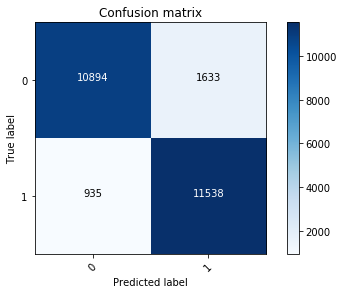

In [21]:
res.plot_confusion_matrix()

Normalized confusion matrix
[[0.86964157 0.13035843]
 [0.07496192 0.92503808]]


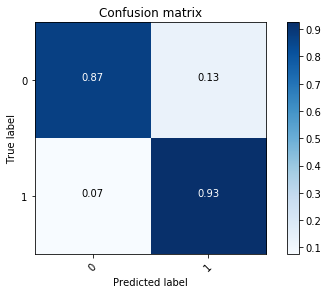

In [22]:
res.plot_confusion_matrix(normalize=True)

## Step 5: Save the pipeline 

Create a path to save your pipeline and model:

In [23]:
pipeline_path = pathlib.Path(resources_dir) / "models" / datetime.datetime.now().strftime("%Y_%m_%d") / "keras_text_classifier_cnn"
if not pipeline_path.exists(): pipeline_path.mkdir(parents=True)
print(pipeline_path)

/home/alizaidi/tatk/resources/models/2018_06_12/keras_text_classifier_cnn


In [24]:
keras_text_classifier.save(str(pipeline_path))

BaseTextModel::save ==> start
TatkPipeline::save ==> start
F1 2018-06-12 19:20:19,312 INFO storing 100002x300 projection weights into /home/alizaidi/tatk/resources/models/2018_06_12/keras_text_classifier_cnn/pipeline/vectorizer/embedding_table.txt
Time taken: 0.24 mins
TatkPipeline::save ==> end
Time taken: 0.24 mins
BaseTextModel::save ==> end


## Step 6: Load the pipeline

In [25]:
loaded_keras_model = keras_text_classifier.load(str(pipeline_path))

BaseTextModel::load ==> start
TatkPipeline::load ==> start
Word2VecVectorizer: neither Word2Vec model nor embedding table file found
Time taken: 0.02 mins
TatkPipeline::load ==> end
Time taken: 0.02 mins
BaseTextModel::load ==> end


KerasEmbeddingTextClassifier ::evaluate ==> start
Time taken: 0.0 mins
KerasEmbeddingTextClassifier ::evaluate ==> end
Normalized confusion matrix
[[0.86964157 0.13035843]
 [0.07496192 0.92503808]]


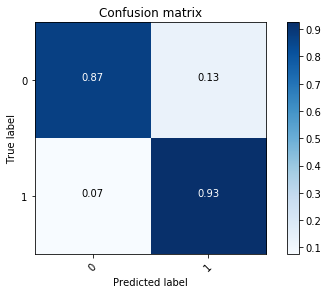

In [26]:
verify_res = loaded_keras_model.evaluate(imdb_test)
verify_res.plot_confusion_matrix(normalize="True")

### Verify the same as before:

In [27]:
(res.cnf_matrix == verify_res.cnf_matrix).all()

True

## Predictions

### You can evaluate on new data. Let's try a hard example:

In [29]:
df_predict = pd.DataFrame({'review' : ["This movie was so bad it was awesome"]})
df_res = keras_text_classifier.predict(df_predict)
df_res

KerasEmbeddingTextClassifier ::predict ==> start
F1 2018-06-12 19:22:10,670 INFO azureml.text:TatkPipeline Prediction starting in experiment 535258228 
F1 2018-06-12 19:22:10,672 INFO azureml.text:8352507970292263481 TatkPipeline::predict ==> start 
F1 2018-06-12 19:22:10,682 INFO azureml.text:8352507970292263481 NltkPreprocessor::tatk_transform ==> start 
NltkPreprocessor::tatk_transform ==> start
F1 2018-06-12 19:22:10,684 INFO azureml.text:8352507970292263481 NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.0 mins 
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.0 mins
F1 2018-06-12 19:22:10,686 INFO azureml.text:8352507970292263481 Word2VecVectorizer::tatk_transform ==> start 
Word2VecVectorizer::tatk_transform ==> start
F1 2018-06-12 19:22:10,756 INFO azureml.text:8352507970292263481 Word2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.0 mins 
Word2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.0 mins
KerasEmbeddingTextClassifierLearner::tatk_predict_

,review,probabilities,prediction
0,This movie was so bad it was awesome,"[0.9488489, 0.051151115]",0


In [35]:
tb_logs = str(pathlib.Path(keras_text_classifier.get_params()["log_dir"]).parent)

In [36]:
def launchTensorBoard(tensorBoardPath=tb_logs):
    import os
    os.system('tensorboard --logdir=' + tensorBoardPath)
    return

In [37]:
from multiprocessing import Process
t = Process(target=launchTensorBoard, args=([]))
t.start()